In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#Imports

In [ ]:
#!pip install wandb
#!pip install torchmetrics
#!pip install albumentations==0.4.6
#!pip install segmentation_models_pytorch

In [2]:
import os
import time
import sys
import math
import string
import random
import shutil
import tarfile
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import torchmetrics

from tqdm import tqdm
from torchsummary import summary

#Preprocessing

In [3]:
tf = tarfile.open(r"C:\Users\malre\Downloads\idd-lite.tar.gz")
tf.extractall()
tf.close()

In [4]:
path = "./idd20k_lite"

print("Folders :\t\t ", os.listdir(path))
print("gtFine :\t\t ", os.listdir(os.path.join(path, "gtFine")))
print("leftImg8bit :\t\t ", os.listdir(os.path.join(path, "leftImg8bit")))
print("\nSCENES")
print("gtFine train:\t\t ", os.listdir(os.path.join(path, "gtFine/train")))  #total scenes
print("\nleftImg8bit train:\t ", os.listdir(os.path.join(path, "leftImg8bit/train")))

print("\n\nFRAMES")
print("leftImg8bit train - 0 : ", os.listdir(os.path.join(path, "leftImg8bit/train/0"))) # frames
print("\ngtFine train - 0 : ", os.listdir(os.path.join(path, "gtFine/train/0")))

Folders :		  ['gtFine', 'leftImg8bit']
gtFine :		  ['train', 'val']
leftImg8bit :		  ['test', 'train', 'val']

SCENES
gtFine train:		  ['0', '1', '10', '100', '101', '102', '104', '106', '108', '11', '110', '115', '116', '117', '118', '121', '122', '124', '125', '126', '127', '128', '130', '131', '133', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '151', '152', '154', '155', '156', '157', '158', '16', '160', '162', '163', '164', '166', '168', '170', '171', '173', '174', '175', '176', '177', '178', '2', '20', '201', '203', '204', '206', '207', '209', '211', '213', '216', '218', '220', '223', '224', '225', '23', '230', '231', '235', '236', '237', '238', '243', '245', '247', '248', '25', '250', '252', '257', '258', '26', '260', '261', '262', '263', '265', '266', '267', '268', '269', '273', '275', '277', '28', '280', '282', '283', '285', '288', '29', '293', '295', '298', '299', '30', '301', '302', '303', '306', '308', '31', '310', '311', '312', '314',

In [5]:
#train dataframe
img_lst, mask_lst = [], []
for img_scene in os.listdir(os.path.join(path, "leftImg8bit/train")):
    imgscene_path = os.path.join(path, f"leftImg8bit/train/{img_scene}")
    maskscene_path = os.path.join(path, f"gtFine/train/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        frame = frame[:-9] + 'label.png'
        maskframe_path = os.path.join(maskscene_path, frame)
        img_lst.append(imgframe_path)
        mask_lst.append(maskframe_path)

data = pd.DataFrame(list(zip(img_lst, mask_lst)), columns = ['images', 'mask'])
data['images'] = sorted(data['images'])
data['mask'] = sorted(data['mask'])

#val dataframe
val_img, val_mask = [], []
for img_scene in os.listdir(os.path.join(path, "leftImg8bit/val")):
    imgscene_path = os.path.join(path, f"leftImg8bit/val/{img_scene}")
    maskscene_path = os.path.join(path, f"gtFine/val/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        frame = frame[:-9] + 'label.png'
        maskframe_path = os.path.join(maskscene_path, frame)
        val_img.append(imgframe_path)
        val_mask.append(maskframe_path)

valdata = pd.DataFrame(list(zip(val_img, val_mask)), columns = ['images', 'mask'])
valdata['images'] = sorted(valdata['images'])
valdata['mask'] = sorted(valdata['mask'])

#test dataframe
test_path = "./idd20k_lite/leftImg8bit/test"
test_imgs = []
for img_scene in os.listdir(test_path):
    imgscene_path = os.path.join(path, f"leftImg8bit/test/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        test_imgs.append(imgframe_path)
test_data = pd.DataFrame(test_imgs, columns = ['images'])    

In [ ]:
data.head()

,images,mask
0,./idd20k_lite\leftImg8bit/train/0\024541_image...,./idd20k_lite\gtFine/train/0\024541_label.png
1,./idd20k_lite\leftImg8bit/train/0\024703_image...,./idd20k_lite\gtFine/train/0\024703_label.png
2,./idd20k_lite\leftImg8bit/train/100\178149_ima...,./idd20k_lite\gtFine/train/100\178149_label.png
3,./idd20k_lite\leftImg8bit/train/100\206998_ima...,./idd20k_lite\gtFine/train/100\206998_label.png
4,./idd20k_lite\leftImg8bit/train/100\296819_ima...,./idd20k_lite\gtFine/train/100\296819_label.png


In [ ]:
valdata.head()

,images,mask
0,./idd20k_lite\leftImg8bit/val/119\903127_image...,./idd20k_lite\gtFine/val/119\903127_label.png
1,./idd20k_lite\leftImg8bit/val/132\475092_image...,./idd20k_lite\gtFine/val/132\475092_label.png
2,./idd20k_lite\leftImg8bit/val/132\489315_image...,./idd20k_lite\gtFine/val/132\489315_label.png
3,./idd20k_lite\leftImg8bit/val/132\874777_image...,./idd20k_lite\gtFine/val/132\874777_label.png
4,./idd20k_lite\leftImg8bit/val/147\425716_image...,./idd20k_lite\gtFine/val/147\425716_label.png


In [ ]:
test_data.head()

,images
0,./idd20k_lite\leftImg8bit/test/103\206393_imag...
1,./idd20k_lite\leftImg8bit/test/103\331011_imag...
2,./idd20k_lite\leftImg8bit/test/103\416301_imag...
3,./idd20k_lite\leftImg8bit/test/103\478626_imag...
4,./idd20k_lite\leftImg8bit/test/103\665169_imag...


In [ ]:
# READING THE MASK TO GET NUM OF UNIQUE CLASSES
u=[]
for ele in data['mask']:
    img = Image.open(ele)
    testImage = np.array(img)
    u+=list((np.unique(testImage)))

print(set(u))
uniq_classes = ['Sky', 'Building','Road','Tree', 'SignSymbol', 'Car', 'Pedestrian', 'unknown']

{0, 1, 2, 3, 4, 5, 6, 255}


In [ ]:
def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
  
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)

        
        list_axes[i].imshow(img)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

In [6]:
# Hyperparameters etc.
BATCH_SIZE = 8
TEST_BATCH_SIZE = 1
NUM_EPOCHS = 30
NUM_WORKERS = 2  
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "checkpoint.pth"

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [30]:
class CustomDataset(Dataset):     #custom dataset
  def __init__(self, data: pd.DataFrame = None,phase='train', transform=None):
    self.data = data
    self.phase = phase
    self.transform = transform
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index): 
    if self.phase=='train':
      img_path = self.data['images'][index]
      mask_path = self.data['mask'][index]
      img = np.array(Image.open(img_path).convert('RGB'))
      mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) #gray-scale
      mask = np.resize(mask,(1,224,320)) # adding column channel
      mask = torch.tensor(mask) ##

      if self.transform:
        img = self.transform(img)
      return img, mask

    if self.phase=='test':
      img_path = self.data['images'][index]
      img = np.array(Image.open(img_path).convert('RGB'))
      if self.transform:
        img = self.transform(img)
      return img
    
    if self.phase == 'val_prediction':
      img_path = self.data['images'][index]
      img = np.array(Image.open(img_path).convert('RGB'))
      if self.transform:
        img = self.transform(img)
      return img

(227, 320, 3) torch.Size([1, 224, 320])


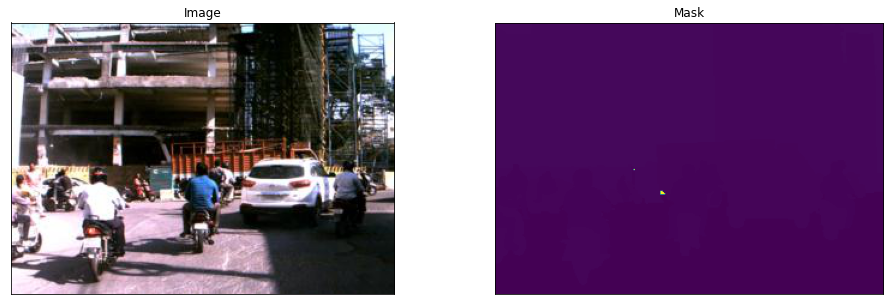

In [ ]:
train_ds = CustomDataset(data)
img, mask = next(iter(train_ds))
print(img.shape, mask.shape)

#VISUALIZE IMAGE AND MASK
visualize(
    image=img, 
    mask=mask.squeeze(),
)

In [8]:
 #transforms              
train_transform = transforms.Compose([           
  transforms.ToTensor(),
  transforms.Resize([224,320]),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

val_transform = transforms.Compose([                          
  transforms.ToTensor(),
  transforms.Resize([224,320]),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

test_transform = transforms.Compose([                          
  transforms.ToTensor(),
  transforms.Resize([224,320]),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [ ]:
train_ds = CustomDataset(data, transform=train_transform)
img, mask = next(iter(train_ds))
print(img.shape, mask.shape)
type(mask)

torch.Size([3, 224, 320]) torch.Size([1, 224, 320])


torch.Tensor

In [9]:
# train & val loader
def get_loaders(data:pd.DataFrame, valdata:pd.DataFrame, batch_size,          # dataloader
                train_transform, val_transform, num_workers=0, pin_memory=True):
    train_ds = CustomDataset(data, transform=train_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_ds = CustomDataset(valdata, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader = get_loaders(data, valdata, BATCH_SIZE, train_transform, val_transform)

dataloaders = {            
  'train': train_loader,
  'val': val_loader,
}

# test_loader
test_dataset = CustomDataset(test_data, phase='test', transform=test_transform)
test_loader =  DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=True)


train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 3, 224, 320])
Labels batch shape: torch.Size([8, 1, 224, 320])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([8, 3, 224, 320])
Labels batch shape: torch.Size([8, 1, 224, 320])


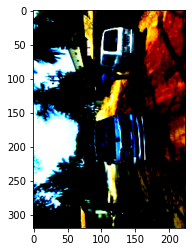

In [ ]:
train_features, train_labels = next(iter(val_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()

#Model

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
    #activation="softmax"  ## An activation function to apply after the final convolution layer
).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\malre/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
summary(model, (3, 224, 320))

In [ ]:
# loss function
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, ignore_index=255, reduction='mean'):
        super(CrossEntropyLoss2d, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target)
        return loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [ ]:
import wandb
wandb.login()

config = dict(
    epochs=NUM_EPOCHS,
    classes=7,
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    dataset="IDDlite",
    architecture="Unet")

In [ ]:
def make(config):
    train_loader_, test_loader_ = train_loader, test_loader
    model_ = model
    criterion_ = CrossEntropyLoss2d()
    optimizer_ = optimizer
    return model_, train_loader_, test_loader_, criterion_, optimizer

def train_log(loss, dicescore, example_ct, epoch):
    wandb.log({"epoch": epoch, "loss": loss, "dicescore": dicescore}, step=example_ct)
    print(f"After {example_ct} examples: LOSS: {loss:.3f}, DICESCORE: {dicescore:.3f}") 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    best_loss = 1e10
    example_ct = 0 
    wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      starttime = time.time()
      batch_ct, epoch_samples = 0, 0
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train() 
          else:
              model.eval()   
          
          for inputs, labels in tqdm(dataloaders[phase]):
              inputs = inputs.to(DEVICE)
              labels = labels.to(DEVICE)
              optimizer.zero_grad()

              if phase == 'train':
                example_ct +=  len(inputs)

              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  dicescore = torchmetrics.functional.dice_score(outputs, labels.long().squeeze(1)) #metric
                  loss = criterion(outputs, labels.long().squeeze(1))  # (b,c,h,w) & (b,h,w)
                  optimizer.zero_grad()
                  epoch_samples += inputs.size(0)
                  epoch_loss = loss / epoch_samples  
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                      # Report metrics every 25th batch
                      batch_ct += 1
                      if ((batch_ct) % 25) == 0:
                        train_log(loss, dicescore, example_ct, epoch)
                            
          if phase == 'train':
            scheduler.step()

          if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), checkpoint_path)

      time_elapsed = time.time() - starttime
    
    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

### Executing the Model

In [ ]:
def model_pipeline(hyperparameters):
    with wandb.init(project="IDDlite", config=hyperparameters):
      config = wandb.config
      model, train_loader, test_loader, criterion, optimizer = make(config)
      train_model(model, criterion, optimizer, exp_lr_scheduler)
      test_model(model, test_loader, viz=True)
    return model

In [ ]:
model = model_pipeline(config)

#Loading from the checkpoint.pth file


In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
    #activation="softmax"  ## An activation function to apply after the final convolution layer
).to(DEVICE)

model_ = model
state_dict = torch.load("./checkpoint.pth")
model_.load_state_dict(state_dict)
model_.eval()

#Comparing Val Mask, Val Prediction

In [103]:
def compare_val(model, valdata: pd.DataFrame,idx=7, phase='val_prediction', transform=test_transform, TEST_BATCH_SIZE=1, device=DEVICE):
  valpath = [valdata['images'][idx]]
  val_img = pd.DataFrame(data=valpath, columns=['images'])
  val_dataset = CustomDataset(val_img, phase=phase, transform=test_transform)
  val_loader = DataLoader(val_dataset, TEST_BATCH_SIZE, shuffle=False)
  

  with torch.no_grad():
    for val_img in val_loader:
      val_img = val_img.to(device) 
      predicted = torch.argmax(model(val_img),dim=1).squeeze().cpu().detach().numpy()

      def get_val_mask(val_img):
        img = val_img.squeeze().cpu().detach().numpy()
        val_mask = np.asarray(Image.open(valdata['mask'][idx]))
        val_img = val_img.cpu().squeeze().numpy()
        val_img = val_img.swapaxes(0, 1)
        val_img = val_img.swapaxes(1, 2)
        return val_img, val_mask
      
      val_img, val_mask = get_val_mask(val_img)
      show_image_list(list_images=[val_img, val_mask, predicted], 
                list_titles=['val_img', 'val_mask', 'predicted'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


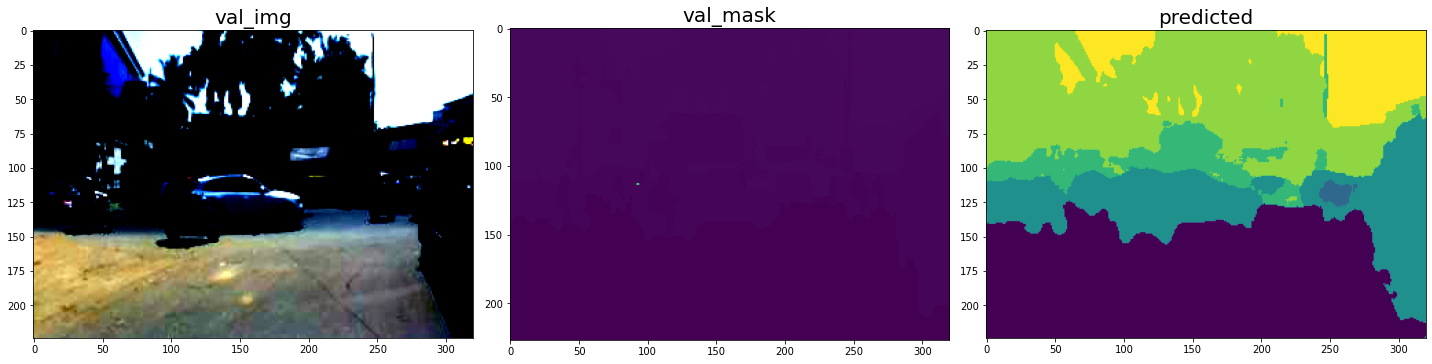

In [133]:
compare_val(model_, valdata, idx=42)

#Predictions on Test Images

In [105]:
def test_model(model, test_loader, viz=False):
  model.eval()
  test_loss = 0
  test_error = 0
  with torch.no_grad():
    for test_img in test_loader:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      test_img = test_img.to(device) 
      output = model(test_img)
      test_img = test_img.squeeze().cpu().detach().numpy()
      test_img = test_img.swapaxes(0, 1)
      test_img = test_img.swapaxes(1, 2)
      
      store_output = output.squeeze().cpu().detach().numpy()
      output = torch.argmax(output,dim=1).squeeze().cpu().detach().numpy()
      background = (output==7)*255
      positive_class = (output<6)*1
      output1 = (output*positive_class)+(background*(1-positive_class))
      if viz==True:
        show_image_list(list_images=[test_img,output1, positive_class, background], 
                list_titles=['test_img', 'output1', 'Positive classes','Background'],
                num_cols=2,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)
        break
  
#test_model(model, test_loader, viz=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


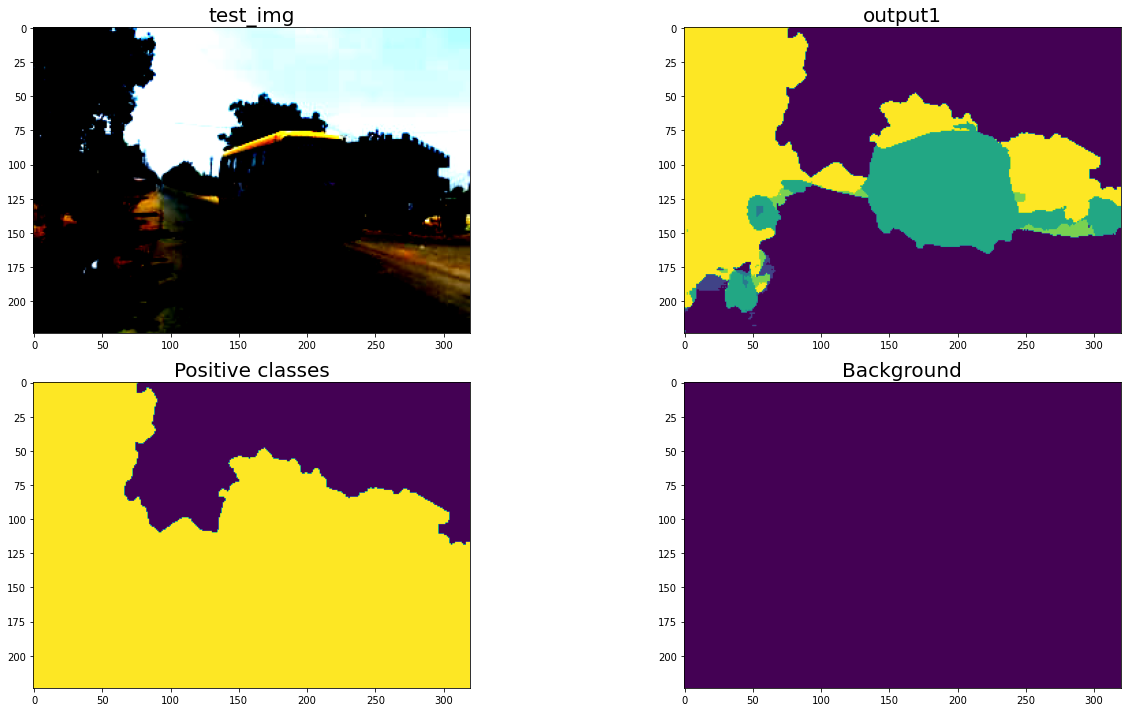

In [126]:
test_model(model_, test_loader, viz=True)